In [22]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
from cmocean import cm
import h5py

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

In [3]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster( walltime='3:00:00')
#w = cluster.scale(5*14)
w = cluster.scale(1*14)

In [24]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [25]:
client

Client Scheduler: tcp://10.148.1.20:47384 Dashboard: http://10.148.1.20:8787/status,Cluster Workers: 2 Cores: 8 Memory: 100.00 GB


---


# 1. Load Drifter dataset

In [26]:
# The prcessed dataset includes both the GPS- and Argo-tracked surface drifters.
# 2-month blocks with overlapping by 50%

data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'

drifter_dataset = h5py.File(data_dir+'Drifter_dataset_processed.mat','r') 
list(drifter_dataset.items())

# mlat2: mean latitude over 60 days,     157978*1
# mlon2: mean longitude over 60 days,    157978*1

# qd: drogued drifters,                  157978*1
# qmed200: median water depth > 200 m,   157978*1
# qu: undrogued drifters,                157978*1

# uv2: (u, v),                           157978*1440

[('dpth2', <HDF5 dataset "dpth2": shape (157978, 1440), type "<f8">),
 ('lat2_err', <HDF5 dataset "lat2_err": shape (157978, 1440), type "<f8">),
 ('lon2_err', <HDF5 dataset "lon2_err": shape (157978, 1440), type "<f8">),
 ('mdpth', <HDF5 dataset "mdpth": shape (157978, 1), type "<f8">),
 ('mlat2', <HDF5 dataset "mlat2": shape (157978, 1), type "<f8">),
 ('mlon2', <HDF5 dataset "mlon2": shape (157978, 1), type "<f8">),
 ('qall1000', <HDF5 dataset "qall1000": shape (157978, 1), type "|u1">),
 ('qall200', <HDF5 dataset "qall200": shape (157978, 1), type "|u1">),
 ('qall500', <HDF5 dataset "qall500": shape (157978, 1), type "|u1">),
 ('qd', <HDF5 dataset "qd": shape (157978, 1), type "|u1">),
 ('qmed1000', <HDF5 dataset "qmed1000": shape (157978, 1), type "|u1">),
 ('qmed200', <HDF5 dataset "qmed200": shape (157978, 1), type "|u1">),
 ('qmed500', <HDF5 dataset "qmed500": shape (157978, 1), type "|u1">),
 ('qu', <HDF5 dataset "qu": shape (157978, 1), type "|u1">),
 ('u2_err', <HDF5 dataset

In [6]:
# turn mean-lat into xarray_DataArray
lat2 = drifter_dataset['mlat2']
lat2 = np.array(lat2)
lat = xr.DataArray(lat2, dims=['lat', 'none'])
lat = xr.DataArray.squeeze(lat, dim='none')
lat = np.real(lat).rename('lat')
lat

<xarray.DataArray 'lat' (lat: 157978)>
array([ 44.219853,  44.908928,  44.856863, ..., -37.524563, -37.171366,
       -37.194084])
Dimensions without coordinates: lat

In [7]:
# turn mean-lat into xarray_DataArray
lon2 = drifter_dataset['mlon2']
lon2 = np.array(lon2)
lon = xr.DataArray(lon2, dims=['lon', 'none'])
lon = xr.DataArray.squeeze(lon, dim='none')
lon = np.real(lon).rename('lon')
lon

<xarray.DataArray 'lon' (lon: 157978)>
array([307.992707, 306.962722, 305.597501, ..., 325.844828, 326.138668,
       325.506414])
Dimensions without coordinates: lon

In [8]:
# turn drogued_information into xarray_DataArray
qd = drifter_dataset['qd']
qd = np.array(qd)
qd = xr.DataArray(qd, dims=['qd', 'none'])
qd = xr.DataArray.squeeze(qd, dim='none')
qd = np.real(qd).rename('qd')
qd

<xarray.DataArray 'qd' (qd: 157978)>
array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)
Dimensions without coordinates: qd

In [9]:
# (u,v) --> u+iv
uv = np.array(drifter_dataset['uv2']).view(np.double).reshape((157978, 1440, 2))
uv_drifters = uv[:,:,0] + 1j*uv[:,:,1]
uv_drifters.shape  # result is (10, 10, 10)
uv_drifters

array([[-0.2048+0.4936j, -0.3023+0.4859j, -0.2971+0.4856j, ...,
         0.1322+0.009j ,  0.1219-0.0239j, -0.0805-0.1172j],
       [ 0.1436+0.2085j,  0.1056+0.1783j,  0.0387+0.128j , ...,
         0.116 +0.075j ,  0.0779+0.2255j,  0.1379+0.195j ],
       [-0.1518-0.1663j, -0.1137-0.1704j, -0.1083-0.1446j, ...,
        -0.2145-0.3872j, -0.215 -0.3862j, -0.2145-0.3976j],
       ...,
       [ 0.3967+0.1554j,  0.4447+0.1624j,  0.4864+0.1736j, ...,
         0.072 +0.2357j,  0.0712+0.2299j,  0.0676+0.2051j],
       [ 0.1061+0.0992j,  0.074 +0.0919j,  0.0629+0.096j , ...,
         0.0589+0.0466j,  0.0513+0.0552j,  0.0395+0.0682j],
       [ 0.0622+0.164j ,  0.0589+0.1348j,  0.0671+0.121j , ...,
        -0.1189+0.0092j, -0.1027-0.0244j, -0.0739-0.0525j]])

In [10]:
# Drifter Dataset (u+iv,lat,qd,time)
ds = xr.Dataset({'uv_drifters': (['lat', 'time'], uv_drifters)},
                 coords={'lat': (['lat'], lat),
                         'lon': (['lat'], lon),
                         'time':(['time'], np.arange(1440)*3600),
                         'qd':(['lat'], qd)})
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:      (lat: 157978, time: 1440)
Coordinates:
  * lat          (lat) float64 44.22 44.91 44.86 43.76 42.22 46.44 46.08 ...
    lon          (lat) float64 308.0 307.0 305.6 305.5 309.8 307.8 307.6 ...
  * time         (time) int64 0 3600 7200 10800 14400 18000 21600 25200 ...
    qd           (lat) uint8 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 ...
Data variables:
    uv_drifters  (lat, time) complex128 (-0.2048+0.4936j) (-0.3023+0.4859j) ...

 data size: 3.6 GB


_________
# 2. Rotary spectra

## 2.1 all drifters

In [11]:
uv_fft_complex = xrft.dft(ds.uv_drifters.fillna(0.), dim=['time'], shift=False, detrend='linear', window=True, chunks_to_segments=False)
E_uv_blocks = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/1440*3600
E_uv_blocks = np.real(E_uv_blocks).rename('E_uv_blocks')
E_uv_blocks = E_uv_blocks.assign_coords(freq_cpd=E_uv_blocks.freq_time * 86400.) 
print(E_uv_blocks)
file_E = data_dir+'E_drifter_uv_blocks.zarr'
%time E_uv_blocks.to_dataset().to_zarr(file_E, mode='w')  

<xarray.DataArray 'E_uv_blocks' (lat: 161841, freq_time: 1440)>
array([[4.144904e+01, 3.854830e+00, 4.197060e+01, ..., 7.093236e+01,
        2.717862e+02, 4.786291e+02],
       [7.151420e+01, 4.998405e+01, 1.577128e+02, ..., 3.761475e+02,
        7.972512e+02, 4.192007e+02],
       [5.365030e+02, 1.141993e+03, 1.366106e+03, ..., 3.949775e+01,
        6.097514e+02, 6.097198e+02],
       ...,
       [5.604732e+02, 1.958392e+03, 1.060817e+04, ..., 1.412836e+03,
        6.680520e+03, 4.213220e+03],
       [5.788188e+02, 1.951424e+02, 7.569457e+01, ..., 1.316694e+03,
        1.368547e+03, 2.636420e+03],
       [3.798517e+02, 1.845695e+03, 1.399439e+03, ..., 1.352164e+03,
        3.481674e+03, 6.464664e+02]])
Coordinates:
  * lat                (lat) float64 44.22 44.91 44.86 43.76 42.22 46.44 ...
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 1.929e-07
    freq_cpd           (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667

## 2.2 undrogued drifters

In [30]:
uv_fft_complex = xrft.dft(ds.uv_drifters.where(ds.qd==0).fillna(0.), dim=['time'], shift=False, detrend='linear', window=True, chunks_to_segments=False)
E_uv_blocks = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/1440*3600
E_uv_blocks = np.real(E_uv_blocks).rename('E_uv_blocks')
E_uv_blocks = E_uv_blocks.assign_coords(freq_cpd=E_uv_blocks.freq_time * 86400.) 
print(E_uv_blocks)
file_E = data_dir+'E_drifter_uv_qu_blocks.zarr'
%time E_uv_blocks.to_dataset().to_zarr(file_E, mode='w')  

<xarray.DataArray 'E_uv_blocks' (lat: 161841, freq_time: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat                (lat) float64 44.22 44.91 44.86 43.76 42.22 46.44 ...
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 1.929e-07
    freq_cpd           (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
CPU times: user 2.45 s, sys: 244 ms, total: 2.7 s
Wall time: 6.87 s


## 2.3 Drogued drifters

In [11]:
uv_fft_complex = xrft.dft(ds.uv_drifters.where(ds.qd==1).fillna(0.), dim=['time'], shift=False, detrend='linear', window=True, chunks_to_segments=False)
E_uv_blocks = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/1440*3600
E_uv_blocks = np.real(E_uv_blocks).rename('E_uv_blocks')
E_uv_blocks = E_uv_blocks.assign_coords(freq_cpd=E_uv_blocks.freq_time * 86400.) 
print(E_uv_blocks)
file_E = data_dir+'E_drifter_uv_qd_blocks.zarr'
%time E_uv_blocks.to_dataset().to_zarr(file_E, mode='w')  

<xarray.DataArray 'E_uv_blocks' (lat: 157978, freq_time: 1440)>
array([[4.144904e+01, 3.854830e+00, 4.197060e+01, ..., 7.093236e+01,
        2.717862e+02, 4.786291e+02],
       [7.151420e+01, 4.998405e+01, 1.577128e+02, ..., 3.761475e+02,
        7.972512e+02, 4.192007e+02],
       [5.365030e+02, 1.141993e+03, 1.366106e+03, ..., 3.949775e+01,
        6.097514e+02, 6.097198e+02],
       ...,
       [5.604732e+02, 1.958392e+03, 1.060817e+04, ..., 1.412836e+03,
        6.680520e+03, 4.213220e+03],
       [5.788188e+02, 1.951424e+02, 7.569457e+01, ..., 1.316694e+03,
        1.368547e+03, 2.636420e+03],
       [3.798517e+02, 1.845695e+03, 1.399439e+03, ..., 1.352164e+03,
        3.481674e+03, 6.464664e+02]])
Coordinates:
  * lat                (lat) float64 44.22 44.91 44.86 43.76 42.22 46.44 ...
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 1.929e-07
    freq_cpd           (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667

_________
# 3. Drifter globally-averaged spectra

## need to change file names to get all, undrogued and drogued results

In [13]:
data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
ds = xr.open_zarr(data_dir+'E_drifter_uv_qd_blocks.zarr').chunk({'freq_time': 1440,'lat': 1000}) 
E_uv_blocks = ds.E_uv_blocks
print(ds)

<xarray.Dataset>
Dimensions:            (freq_time: 1440, lat: 157978)
Coordinates:
    freq_cpd           (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 ...
  * lat                (lat) float64 44.22 44.91 44.86 43.76 42.22 46.44 ...
Data variables:
    E_uv_blocks        (lat, freq_time) float64 dask.array<shape=(157978, 1440), chunksize=(1000, 1440)>


In [25]:
# cyclonic spectra
E_uv_1 = ((E_uv_blocks).where( (E_uv_blocks.lat>0.) & (E_uv_blocks.freq_time>0.) )).mean(dim=('lat'))   
E_uv_1 = np.real(E_uv_1).rename('E_uv_1')
E_uv_1 

E_uv_2 = ((E_uv_blocks).where( (E_uv_blocks.lat<0.) & (E_uv_blocks.freq_time<0.) )).mean(dim=('lat'))   
E_uv_2 = E_uv_2.assign_coords(freq_time=E_uv_2.freq_time * -1.) 
E_uv_2 = np.real(E_uv_2).rename('E_uv_2')
E_uv_2 

E_drifter_cycl = (E_uv_1 + E_uv_2)/8.64 #(unit:cm^2 s^-2/cpd)
E_drifter_cycl = E_drifter_cycl.assign_coords(freq_time=E_drifter_cycl.freq_time * 86400.) 
E_drifter_cycl

<xarray.DataArray (freq_time: 1439)>
array([        nan, 6742.909634, 4728.414716, ...,         nan,         nan,
               nan])
Coordinates:
  * freq_time          (freq_time) float64 -0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07

In [26]:
# anti-cyclonic spectra
E_uv_3 = ((E_uv_blocks).where( (E_uv_blocks.lat<0.) & (E_uv_blocks.freq_time>0.) )).mean(dim=('lat'))   
E_uv_3 = np.real(E_uv_3).rename('E_uv_3') 

E_uv_4 = ((E_uv_blocks).where( (E_uv_blocks.lat>0.) & (E_uv_blocks.freq_time<0.) )).mean(dim=('lat'))   
E_uv_4 = E_uv_4.assign_coords(freq_time=E_uv_4.freq_time * -1.) 
E_uv_4 = np.real(E_uv_4).rename('E_uv_4')
E_uv_4 

E_drifter_anti = (E_uv_3 + E_uv_4)/8.64 #(unit:cm^2 s^-2/cpd)
E_drifter_anti = E_drifter_anti.assign_coords(freq_time=E_drifter_anti.freq_time * 86400.) 
E_drifter_anti

<xarray.DataArray (freq_time: 1439)>
array([        nan, 7962.848   , 5934.999689, ...,         nan,         nan,
               nan])
Coordinates:
  * freq_time          (freq_time) float64 -0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07

In [15]:
E_drifter_cycl = np.real(E_drifter_cycl).rename('E_drifter_cycl')
E_drifter_anti = np.real(E_drifter_anti).rename('E_drifter_anti')
E_drifter_globalmean = xr.merge([E_drifter_cycl.to_dataset(),E_drifter_anti.to_dataset()])
print(E_drifter_globalmean)
file_E = data_dir+'E_drifter_qd_globalmean.zarr'
%time E_drifter_globalmean.to_zarr(file_E, mode='w')  

<xarray.Dataset>
Dimensions:            (freq_time: 1439)
Coordinates:
  * freq_time          (freq_time) float64 -0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07
Data variables:
    E_drifter_cycl     (freq_time) float64 dask.array<shape=(1439,), chunksize=(1439,)>
    E_drifter_anti     (freq_time) float64 dask.array<shape=(1439,), chunksize=(1439,)>
CPU times: user 5.44 s, sys: 1.32 s, total: 6.77 s
Wall time: 10.6 s


_______________
# 4. Plots

In [27]:
# drogued
data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
ds = xr.open_zarr(data_dir+'E_drifter_qd_globalmean.zarr')
print(ds)
E_drifter_anti_qd = ds.E_drifter_anti
E_drifter_cycl_qd = ds.E_drifter_cycl

<xarray.Dataset>
Dimensions:            (freq_time: 1439)
Coordinates:
  * freq_time          (freq_time) float64 -0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 ...
Data variables:
    E_drifter_anti     (freq_time) float64 dask.array<shape=(1439,), chunksize=(1439,)>
    E_drifter_cycl     (freq_time) float64 dask.array<shape=(1439,), chunksize=(1439,)>


In [28]:
# undrogued
data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
ds = xr.open_zarr(data_dir+'E_drifter_qu_globalmean.zarr')
print(ds)
E_drifter_anti_qu = ds.E_drifter_anti
E_drifter_cycl_qu = ds.E_drifter_cycl

<xarray.Dataset>
Dimensions:            (freq_time: 1439)
Coordinates:
  * freq_time          (freq_time) float64 -0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 ...
Data variables:
    E_drifter_anti     (freq_time) float64 dask.array<shape=(1439,), chunksize=(1439,)>
    E_drifter_cycl     (freq_time) float64 dask.array<shape=(1439,), chunksize=(1439,)>


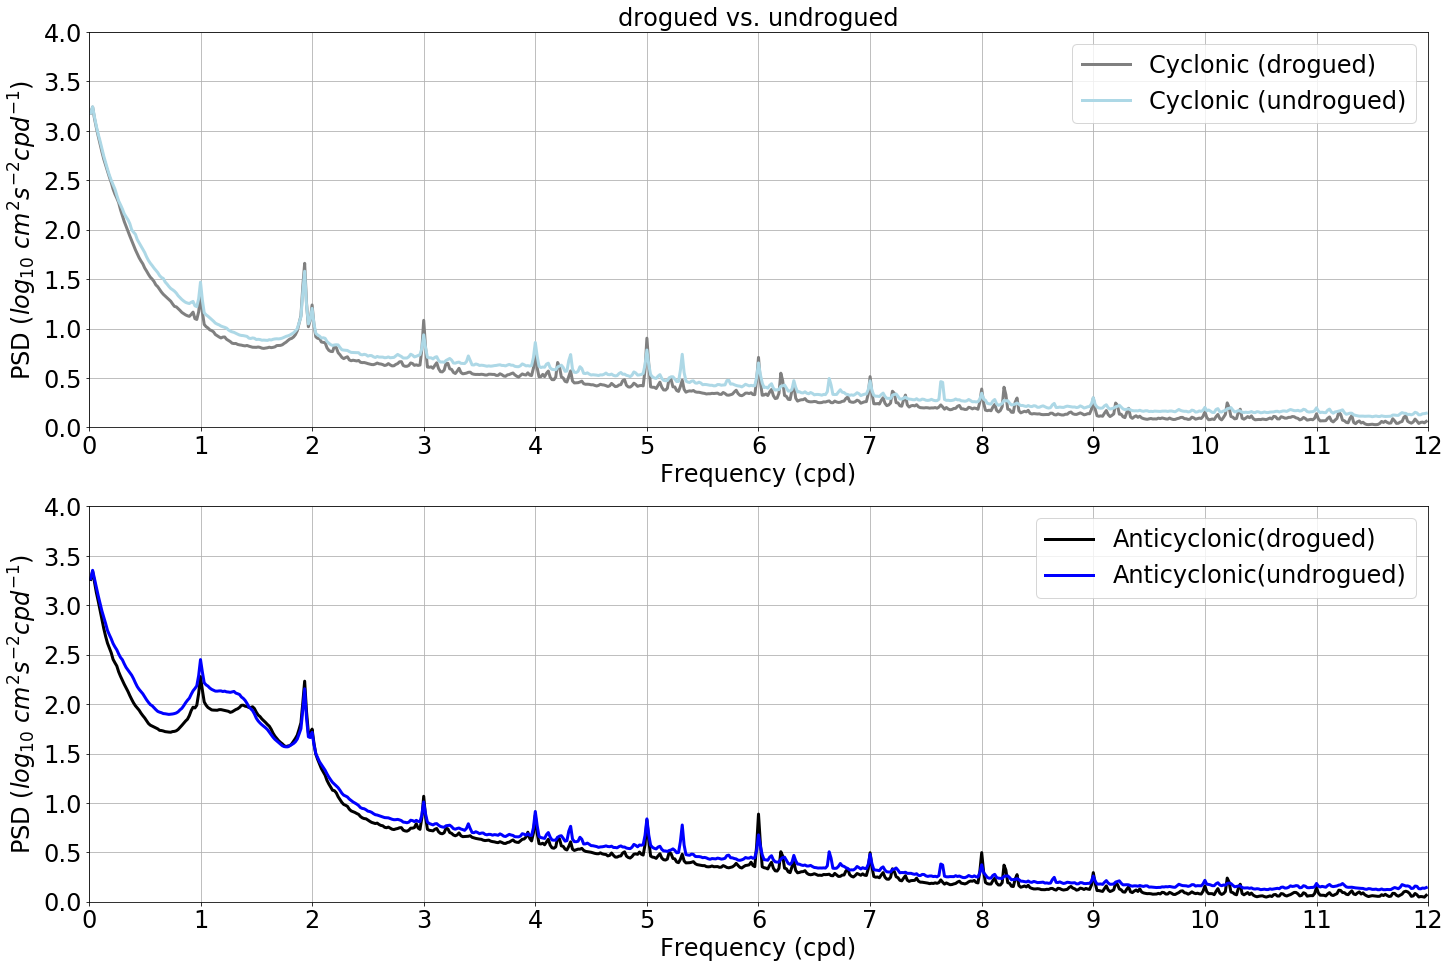

In [29]:
fig, ax = plt.subplots(figsize=(24,16))

labels = ['Cyclonic (drogued)', 'Anticyclonic(drogued)', 'Cyclonic (undrogued)', 'Anticyclonic(undrogued)']

# LLC4320
ax = plt.subplot(2,1,1)
np.log10(E_drifter_cycl_qd).plot(ax=ax, linewidth=3, color='grey', label=labels[0])
#np.log10(E_drifter_anti_qd).plot(ax=ax, linewidth=3, color='black', label=labels[1])
np.log10(E_drifter_cycl_qu).plot(ax=ax, linewidth=3, color='lightblue', label=labels[2])
#np.log10(E_drifter_anti_qu).plot(ax=ax, linewidth=3, color='blue', label=labels[3])
ax.legend(); ax.grid()
ax.set_ylim([0.,4])
ax.set_yticks([0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5,4.])
ax.set_xlim([0.,12.])
ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('drogued vs. undrogued',fontsize=24)


ax = plt.subplot(2,1,2)
labels = ['Cyclonic (drogued)', 'Anticyclonic(drogued)', 'Cyclonic (undrogued)', 'Anticyclonic(undrogued)']
#np.log10(E_drifter_cycl_qd).plot(ax=ax, linewidth=3, color='grey', label=labels[0])
np.log10(E_drifter_anti_qd).plot(ax=ax, linewidth=3, color='black', label=labels[1])
#np.log10(E_drifter_cycl_qu).plot(ax=ax, linewidth=3, color='lightblue', label=labels[2])
np.log10(E_drifter_anti_qu).plot(ax=ax, linewidth=3, color='blue', label=labels[3])
ax.legend(); ax.grid()
ax.set_ylim([0.,4])
ax.set_yticks([0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5,4.])
ax.set_xlim([0.,12.])
ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('',fontsize=24)

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_drogued_undrogued_globally_averaged.png')

In [31]:
cluster.close()

<Future finished result=None>